In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from plotnine import *
import glob

import os
import sys
import time
sys.path.insert(0, "../mosaicperm/")
import mosaicperm as mp
from mosaicperm.utilities import vrange, elapsed

def calc_mean_sem(data, group_vals, meas, trunc_zero=True):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column.
    """
    agg_df = data.groupby(group_vals)[meas].agg(['mean', 'std', 'sem']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['mean']
        agg_df[f'{m}_std'] = agg_df[m]['std']
        agg_df[f'{m}_sem'] = agg_df[m]['sem']
        agg_df[f'{m}_ymin'] =  agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_sem']
        if trunc_zero:
            agg_df[f'{m}_ymin'] = np.maximum(0, agg_df[f'{m}_ymin'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_sem']
    
    agg_df = agg_df.loc[:, agg_df.columns.get_level_values(1) == '']
    agg_df.columns = agg_df.columns.get_level_values(0)
    return agg_df

In [2]:
def naive_plugin(hateps, test_stat, R=100):
    """
    Perform naive permutation test on hateps OLS.
    """
    n, p = hateps.shape
    S = test_stat(hateps)
    hatepsr = hateps.copy()
    inds = np.arange(n)
    S0s = np.zeros(R)
    for r in vrange(R, verbose=False):
        for j in range(p):
            np.random.shuffle(inds)
            hatepsr[:, j] = hateps[:, j][inds]
        S0s[r] = test_stat(hatepsr)
    pval = (1 + np.sum(S <= S0s)) / (R + 1)
    return pval, S, S0s

def resid_bootstrap(hateps, test_stat, R=100):
    """
    Residual bootstrap from paper.
    """
    n, p = hateps.shape
    S = test_stat(hateps)
    hatepsr = hateps.copy()
    inds = np.arange(n)
    S0s = np.zeros(R)
    for r in vrange(R, verbose=False):
        #for j in range(p):
        #    hatepsr[:, j] = np.random.choice(hateps[:,j], size=n, replace=True)
        S0s[r] = test_stat(hateps[np.random.choice(inds, size=n, replace=True)])
    pval = (1 + np.sum(S <= S0s)) / (R + 1)
    return pval, S, S0s

def bootstrap(Y, H, test_stat, R=100):
    """
    Nonparametric bootstrap (identical to residual bootstrap when exposures are constant).
    """
    n, p = Y.shape
    # OLS
    hateps = Y @ H
    S = test_stat(hateps)
    # Bootstrap
    inds = np.arange(n)
    S0s = np.zeros(R)
    for r in vrange(R, verbose=False):
        Ynew = Y[np.random.choice(inds, size=n, replace=True)]
        S0s[r] = test_stat(Ynew @ H)
    pval = (1 + np.sum(S <= S0s)) / (R + 1)
    return pval, S, S0s

## 1. Invalidity of bootstrap

In [3]:
# Load factor exposures
L_PATH = "data/bfre_cache/simulation_exposures_EGY.npy"
L_PLACEHOLDER_PATH = "data/bfre_placeholder/simulation_exposures_EGY.npy"
if os.path.exists(L_PATH):
    L = np.load(L_PATH)
else:
    print("True exposures are not publicly available, using placeholder data instead.")
    L = np.load(L_PLACEHOLDER_PATH)

In [4]:
# bootstrap distribution
reps = 1000
bs_reps = 50
nboot_reps = reps
Ts = []
Ts_bs = np.zeros((reps, bs_reps))
#Ts_resid_bs = [] ## bootstrap and resid bootstrap are the same
Ts_naive = []
Ts_mosaic_null = []
Ts_mosaic = []

# test statistic
def test_stat(x):
    return mp.statistics.mean_maxcorr_stat(x)

t0 = time.time()
# Projection matrix
p, k = L.shape
H = np.eye(p) - L @ np.linalg.pinv(L.T @ L) @ L.T
for rep in tqdm(list(range(reps))):
    for n in [350]:
        # Sample Y
        np.random.seed(rep)
        X = np.random.randn(n, k)
        eps = np.random.randn(n, p)
        Y = X @ L.T + eps
        # Compute hateps
        hateps = Y @ H
        # Compute p-values
        Ts.append(test_stat(hateps))
        if rep <= nboot_reps:
            ## bootstrap
            # these are equivalent
            #_, _, S0s = bootstrap(Y, H, test_stat, R=bs_reps)
            _, _, S0s = resid_bootstrap(hateps, test_stat, R=bs_reps)
            Ts_bs[rep] = S0s
            # naive perm
            _, _, S0s = naive_plugin(hateps, test_stat, R=1)
            Ts_naive.append(S0s[0])
            
        # mosaic
        mptest = mp.factor.MosaicFactorTest(outcomes=Y, exposures=L, test_stat=test_stat)
        mptest.fit(nrand=1, verbose=False)
        Ts_mosaic.append(mptest.statistic)
        Ts_mosaic_null.append(mptest.null_statistics.item())
        
Ts_mosaic = np.array(Ts_mosaic)
Ts_mosaic_null = np.array(Ts_mosaic_null)
Ts_bs = np.array(Ts_bs)
#Ts_resid_bs = np.array(Ts_resid_bs)
Ts_naive = np.array(Ts_naive)
Ts = np.array(Ts)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:15<00:00,  5.11it/s]


In [5]:
bs_bias = np.mean(Ts_bs, axis=1) - Ts
Zs_bs = (Ts - bs_bias) / np.std(Ts_bs, axis=1)
Zs_gaussian = np.random.randn(reps)
bs_bias.mean(), Ts.mean()

(0.057143266182997136, 0.17301978116280536)

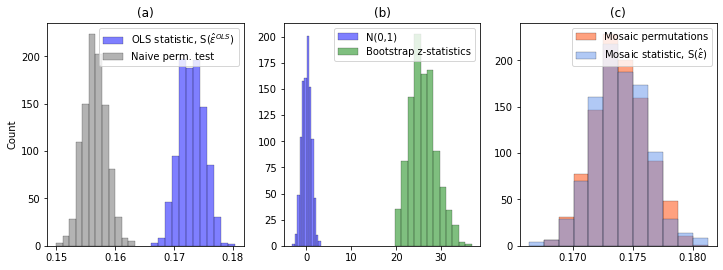

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.1))
olslab = 'OLS statistic, S($\hat\epsilon^{OLS}$)'

# Bins for plotting
mondmin = min(Ts_mosaic.min(), Ts_mosaic_null.min())
mondmax = max(Ts_mosaic.max(), Ts_mosaic_null.max())
mondbins = np.linspace(mondmin, mondmax, 13)

for axnum, color, stats, label in zip(
    [1, 1, 0, 0, 2, 2],
    ['blue', 'green', 'blue', 'dimgray', 'orangered', 'cornflowerblue'],
    [Zs_gaussian, Zs_bs, Ts, Ts_naive, Ts_mosaic_null, Ts_mosaic],
    [
        "N(0,1)", 'Bootstrap z-statistics', olslab, 'Naive perm. test',
        'Mosaic permutations', r'Mosaic statistic, S($\hat\epsilon$)'
    ],
):
    ax = axes[axnum]
    sns.histplot(
        stats, 
        color=color, 
        alpha=0.5, 
        ax=ax, 
        label=label,
        linewidth=0.2,
        bins=mondbins if 'Mosaic' in label else 12,
    )
    if axnum != 0:
        axes[axnum].set(ylabel='')
    #axes[axnum].set_ylim(0, 315)
    
for axchar, ax in zip(['a', 'b', 'c'], axes):
    ax.set(title=f"({axchar})")
for ax in axes:
    ax.legend()
    
plt.savefig("plots/naive_methods.png", dpi=500, bbox_inches='tight')
plt.show()

## 2. Power comparisons with OLS

In [7]:
# will become 52618321
jobids = [52618321]
#jobids = [51648551, 51648896]
df = []
for jobid in jobids:
    fnames = glob.glob(f"sim_data/main_sims/*/*/*{jobid}*.csv")
    for fname in fnames:
        df.append(pd.read_csv(fname))
df = pd.concat(df, axis='index')
alpha = 0.05
#df = df.loc[df['n'] == 200]

In [8]:
## OLS thresholds
ols_sub = df.loc[df['method'].str.contains("OLS")].copy()
group_vals = ['sparsity', 'test_stat', 'test_stat_index', 'method', 'n', 'eps_dist']
thresh = ols_sub.loc[ols_sub['rho'] == 0].groupby(group_vals)['T'].quantile(1-alpha)
thresh = thresh.reset_index().rename(columns={"T":"threshold"})
ols_sub = pd.merge(
    ols_sub, thresh, on=group_vals, how='left'
)
ols_sub['disc'] = ols_sub['T'] > ols_sub['threshold']
## Mondrian results
mpt_sub = df.loc[~df['method'].str.contains("OLS")].copy()
mpt_sub['disc'] = (mpt_sub['pval'] <= alpha).astype(float)
## final df
fdf = pd.concat([mpt_sub, ols_sub], axis='index').drop("threshold", axis='columns')
## aggregate statistics
agg = calc_mean_sem(
    fdf,
    group_vals=group_vals+['rho'],
    meas=['disc']
)

In [9]:
mpt_adaptive = agg.loc[
    (agg['method'] == 'MPT') 
    & (agg['test_stat_index'] == 'adaptive')
]
# A-priori maximum
nonadapt = agg.loc[agg['test_stat_index'] != 'adaptive']
ids = nonadapt.groupby(
    list(set(group_vals+['rho']) - set(['test_stat_index']))
)['disc_mean'].idxmax().values
oracle_index_stats = nonadapt.loc[ids]
oracle_index_stats['test_stat_index'] = 'oracle'
## to plot
df4plot = pd.concat([oracle_index_stats, mpt_adaptive], axis='index')

In [10]:
df4plot['Method'] = (df4plot['method'] + df4plot['test_stat_index']).map({
    "MPTadaptive":"MPT (adaptive)",
    "MPToracle":"MPT (oracle)",
    "OLS oracleoracle":r"OLS (double oracle)"
})

In [11]:
comparisons = []
for n in df4plot['n'].unique():
    for eps_dist in df4plot['eps_dist'].unique():
        for sparsity in df4plot['sparsity'].unique():
            # Consider one value of sparsity and n
            sub = df4plot.loc[
                (df4plot['sparsity'] == sparsity) &
                (df4plot['n'] == n) &
                (df4plot['eps_dist'] == eps_dist)
            ]
            if len(sub) == 0:
                continue
            for rho in sub['rho'].unique():
                subrho = sub.loc[sub['rho'] == rho]
                # For this value of rho, find the power of the two methods with the same test statistic
                power_mpt = subrho.loc[subrho['Method'] == 'MPT (oracle)', 'disc_mean'].item()
                power_ols = subrho.loc[subrho['Method'] == 'OLS (double oracle)', 'disc_mean'].item()
                # find minimum value of rho where MPT (oracle) exceeds OLS
                minrho = sub.loc[
                    (sub['Method'] == 'MPT (oracle)') &
                    (sub['disc_mean'] >= power_ols),
                    'rho'
                ].min()
                comparisons.append([n, sparsity, eps_dist, rho, power_ols, power_mpt, minrho])

comparisons = pd.DataFrame(comparisons, columns=['n', 'sparsity', 'eps_dist', 'rho', 'power_ols', 'power_mpt', 'minrho'])

In [12]:
comparisons['power_diff'] = comparisons['power_ols'] - comparisons['power_mpt']
#comparisons['rho_ratio'] = comparisons['minrho'] / comparisons['rho']
display(comparisons.groupby(['n', 'sparsity', 'eps_dist'])['power_diff'].max())
print(f"Average power difference is {comparisons['power_diff'].mean()}")

n   sparsity  eps_dist
50  0.05      tdist       0.046
    0.15      tdist       0.100
    0.30      tdist       0.094
Name: power_diff, dtype: float64

Average power difference is 0.0312


/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 3 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/main_sim_results.png
/tmp/ipykernel_5488/999841396.py:21: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


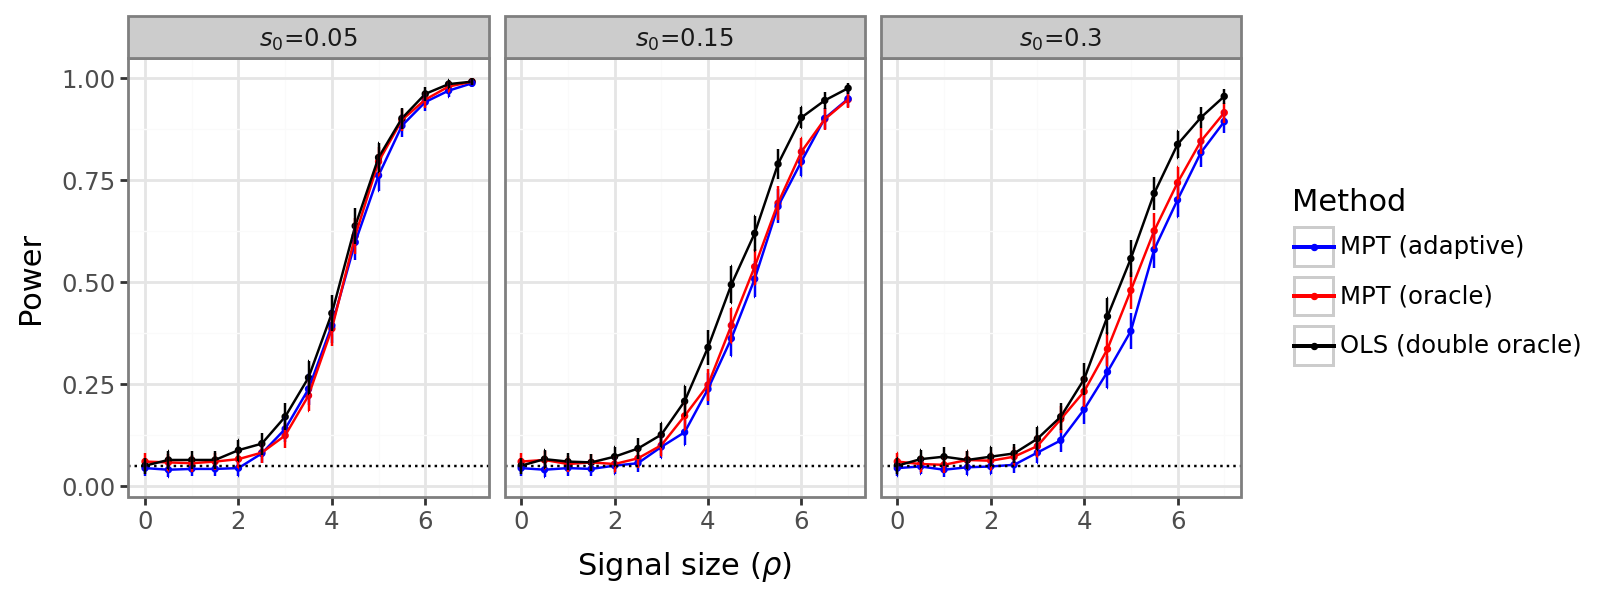

In [13]:
meas = 'disc'
g = (
    ggplot(
        df4plot.loc[
            (df4plot['test_stat'] == 'quant_corr')],
        aes(x='rho', y=f'{meas}_mean', color='Method')
    ) 
    + geom_point(size=0.5)
    + geom_line()
    + geom_errorbar(aes(ymin=meas+"_ymin", ymax=meas+"_ymax"), width=0.01)
    + facet_wrap("~sparsity", labeller=lambda x: rf"$s_0$={x}", nrow=1)
    + theme_bw()
    + theme(figure_size=(8,3))
    + geom_hline(yintercept=alpha, color='black', linetype='dotted')
    + scale_color_manual(['blue', 'red', 'black'])
    + labs(
        x=r'Signal size ($\rho$)', y='Power', 
    )
)
g.save("plots/main_sim_results.png", dpi=500)
print(g)